In [17]:
import pandas as pd 
import os

TICKER_DIR = "C:\\Users\\anton\\Documents\\antoniouaa\\msc_thesis\\data\\tickers\\ticker_data\\_Rolling"
datasets = []
for f in os.listdir(TICKER_DIR):
    df = pd.read_csv(os.path.join(TICKER_DIR, f), header=0)
    datasets.append(df)

dataset = pd.concat(datasets)
dataset = dataset.dropna(how="any")
dataset

,close,high,low,open,volume,R.Mean,R.std,S0%k,EMA,BolBand1,BolBand2
13,102.39,103.28,102.22,102.641,4451,102.100121,0.917114,63.636364,102.249329,0.035930,0.579019
14,103.54,105.00,103.14,103.140,5098,102.310121,0.883166,100.000000,102.444197,0.034529,0.848145
15,104.15,104.23,103.25,103.250,4766,102.472979,0.998456,100.000000,102.697275,0.038974,0.919904
16,103.00,104.40,101.28,103.460,15545,102.547979,0.995582,67.877095,102.741524,0.038834,0.613507
17,103.19,103.58,101.87,103.580,15521,102.682264,0.941052,73.184358,102.806245,0.036659,0.634885
...,...,...,...,...,...,...,...,...,...,...,...
227,18.53,18.67,18.44,18.630,4639037,18.677143,0.188656,18.518519,18.556643,0.040404,0.305012
228,18.65,18.69,18.43,18.430,3518060,18.689286,0.180276,40.740741,18.569090,0.038584,0.445520
229,18.85,18.99,18.70,18.760,6335675,18.715000,0.175269,77.777778,18.606545,0.037461,0.692561
230,18.68,18.89,18.60,18.830,4250416,18.694286,0.159215,54.347826,18.616339,0.034067,0.477569


In [18]:
import numpy as np 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator

values = dataset.to_numpy()

scaler = StandardScaler()
scaled = scaler.fit_transform(values)

X = scaled[:][:-154] # 11 features * 14 days 
y = scaled[:, 0][154:]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
timesteps = 14
train_generator = TimeseriesGenerator(X_train, y_train, length=timesteps, sampling_rate=1, batch_size=timesteps)
test_generator = TimeseriesGenerator(X_test, y_test, length=timesteps, sampling_rate=1, batch_size=timesteps)

In [19]:
X_train, y_train = train_generator[0]
X_test, y_test = test_generator[0]

train_samples = X_train.shape[0] * len(train_generator)
test_samples = X_test.shape[0] * len(test_generator)

In [20]:
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.layers.advanced_activations import LeakyReLU

units = 128
epochs = 100
learning_rate = 0.001
x_shape = X_train.shape
print(x_shape)
model = Sequential()
model.add(LSTM(units, input_shape=(x_shape[1], x_shape[2])))
model.add(LeakyReLU(alpha=0.5))
model.add(Dropout(0.1))
model.add(Dense(1))

adam = Adam(lr=learning_rate)
model.compile(loss="mse", optimizer=adam, metrics=["mae"])

history = model.fit_generator(train_generator, 
    epochs=epochs,
    validation_data=test_generator,
    verbose=1,
    shuffle=False,
    initial_epoch=0)

score = model.evaluate_generator(test_generator, verbose=0)

(14, 14, 11)
Epoch 1/100
329/329 [==============================] - 3s 10ms/step - loss: 0.9842 - mae: 0.6704 - val_loss: 0.3737 - val_mae: 0.6827
Epoch 2/100
329/329 [==============================] - 3s 9ms/step - loss: 0.9745 - mae: 0.6680 - val_loss: 0.3873 - val_mae: 0.6825
Epoch 3/100
329/329 [==============================] - 3s 8ms/step - loss: 0.9722 - mae: 0.6678 - val_loss: 0.3822 - val_mae: 0.6833
Epoch 4/100
329/329 [==============================] - 3s 8ms/step - loss: 0.9682 - mae: 0.6665 - val_loss: 0.3887 - val_mae: 0.6859
Epoch 5/100
329/329 [==============================] - 3s 8ms/step - loss: 0.9663 - mae: 0.6661 - val_loss: 0.3956 - val_mae: 0.6889
Epoch 6/100
329/329 [==============================] - 3s 8ms/step - loss: 0.9636 - mae: 0.6644 - val_loss: 0.3872 - val_mae: 0.6862
Epoch 7/100
329/329 [==============================] - 3s 8ms/step - loss: 0.9593 - mae: 0.6626 - val_loss: 0.3997 - val_mae: 0.6936
Epoch 8/100
329/329 [==============================] - 

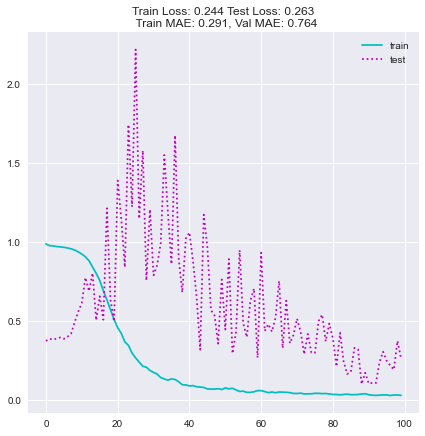

In [22]:
import matplotlib.pyplot as plt 

train_loss = np.mean(history.history["loss"])
train_mae = np.mean(history.history["mae"])
title = f'Train Loss: {train_loss:.3f} Test Loss: {score[0]:.3f}\n  Train MAE: {train_mae:.3f}, Val MAE: {score[1]:.3f}'
fig = plt.figure()
plt.style.use("seaborn")
plt.plot(history.history["loss"], "c-", label="train")
plt.plot(history.history["val_loss"], "m:", label="test")
plt.title(title)
plt.legend()
fig.set_size_inches(w=7, h=7)
plt.close()
display(fig)
fig.savefig(f"C:\\Users\\anton\\Documents\\antoniouaa\\msc_thesis\\assets\\ALL_TICKERS.jpg")